In [2]:
import glob, os
import numpy as np 
import pandas as pd 
import seaborn as sns
import librosa.display
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
from librosa.feature import mfcc

In [2]:
seed = 42 
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# check there are bad files 
bad_files = []
for file in glob.glob('data/TESS/*/*.*'):
    filename = file.replace('\\', '/')
    try:
        raw_audio = tf.io.read_file(filename)
        waveform = tf.audio.decode_wav(raw_audio)
    except:
        os.remove(filename)
        print(f"Bad file: {filename}")

In [4]:
def load_dataset(audio_dir = 'data/TESS'):
    train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
                                                                audio_dir,
                                                                seed=seed,
                                                                batch_size=32,
                                                                output_sequence_length=16000,
                                                                validation_split=0.15,
                                                                subset='both'
                                                                )
    return train_ds, val_ds

In [5]:
train_ds, val_ds = load_dataset()
label_names = np.array(train_ds.class_names)
train_ds = train_ds.concatenate(val_ds)
print()
print("label names:", label_names)

Found 10241 files belonging to 7 classes.
Using 8705 files for training.
Using 1536 files for validation.

label names: ['Angry' 'Fear' 'Happy' 'Neutral' 'Pleasant_surprise' 'Sad' 'disgust']


In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [7]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [8]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(32, 16000)
(32,)


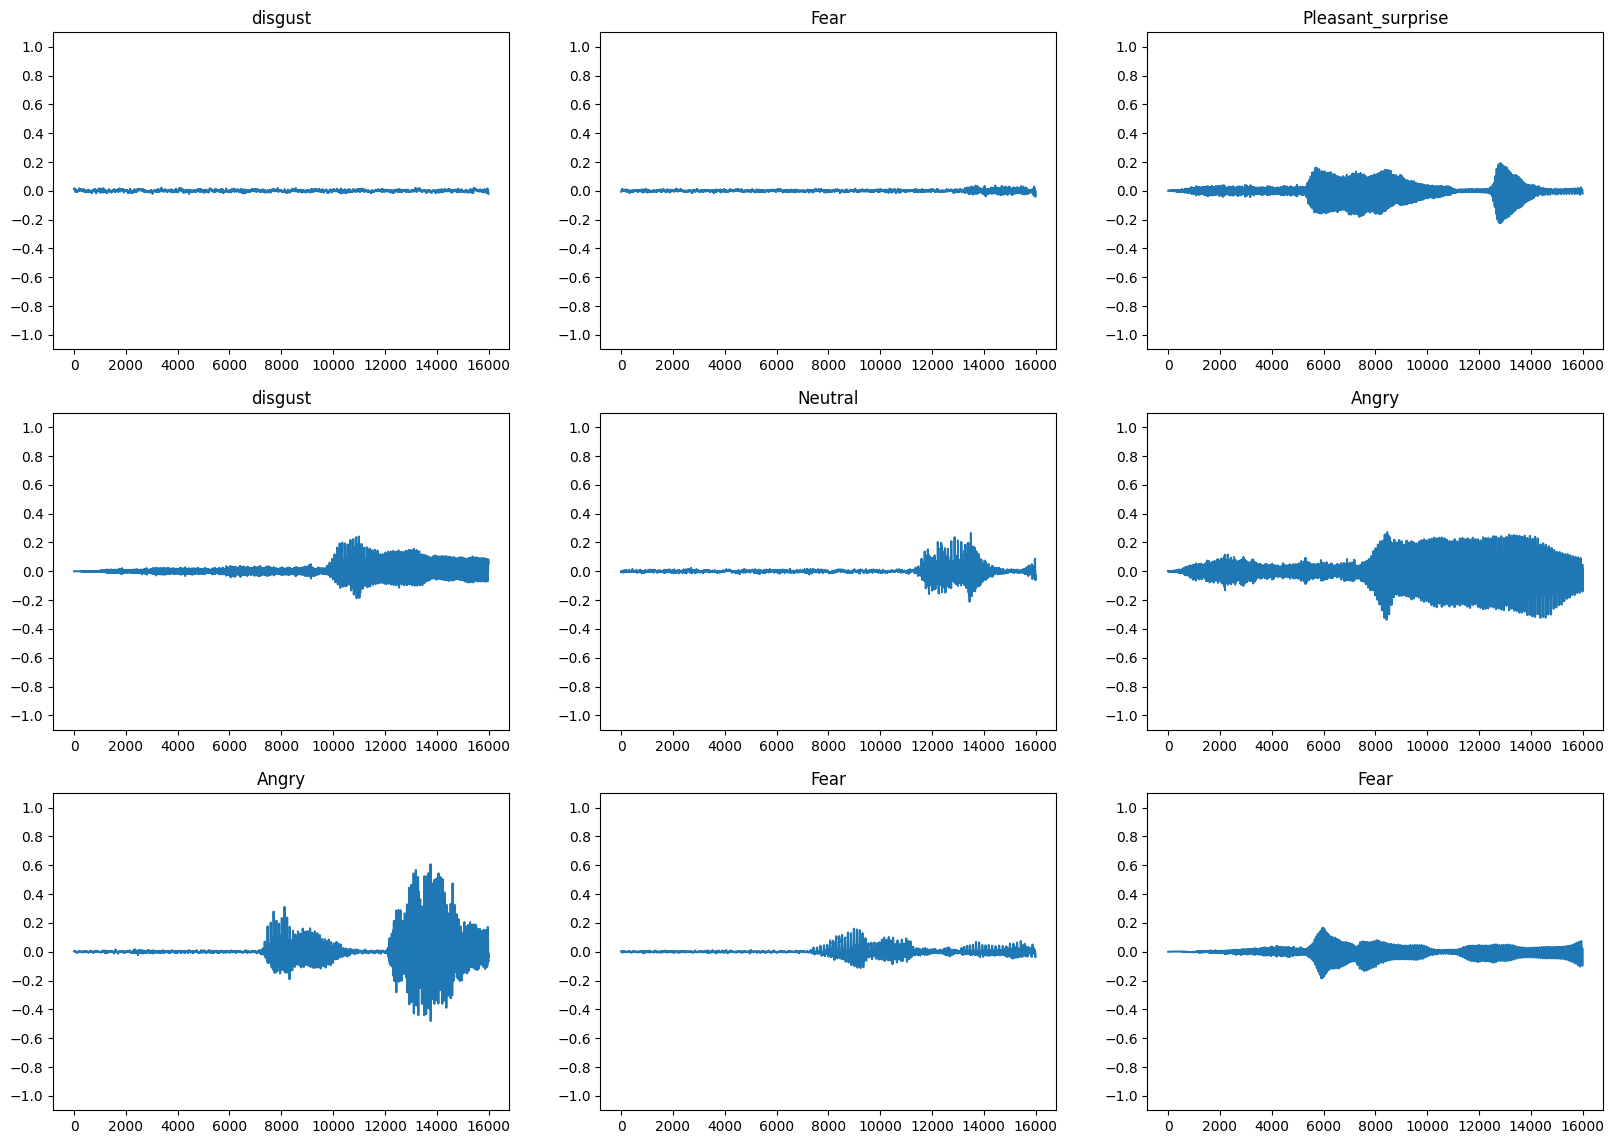

In [9]:
plt.figure(figsize=(20, 14))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [10]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
                                waveform, 
                                frame_length=255, 
                                frame_step=128
                                )
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [41]:
for i in range(7):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    ipd.display(ipd.Audio(waveform, rate=16000))

(124, 129, 1)
Label: disgust
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


(124, 129, 1)
Label: Fear
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


(124, 129, 1)
Label: Pleasant_surprise
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


(124, 129, 1)
Label: disgust
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


(124, 129, 1)
Label: Neutral
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


(124, 129, 1)
Label: Angry
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


(124, 129, 1)
Label: Angry
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [12]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)

    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

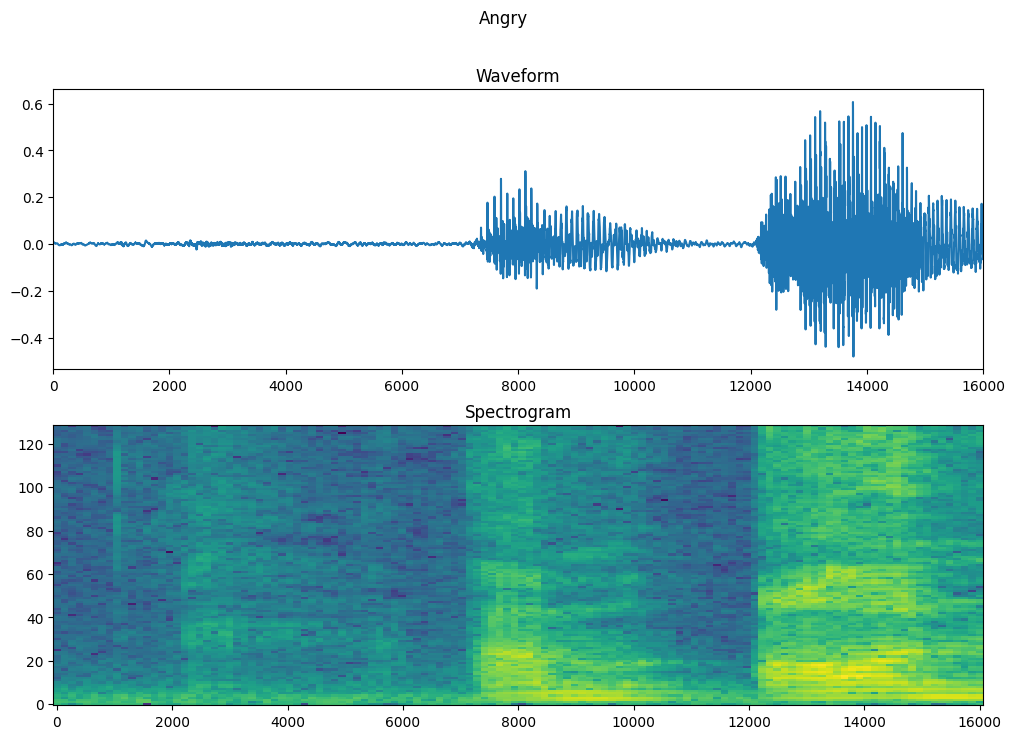

In [13]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [14]:
def make_spec_ds(ds):
    return ds.map(
                map_func=lambda audio,label: (get_spectrogram(audio), tf.one_hot(label, depth=len(label_names))),
                )

In [15]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [16]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

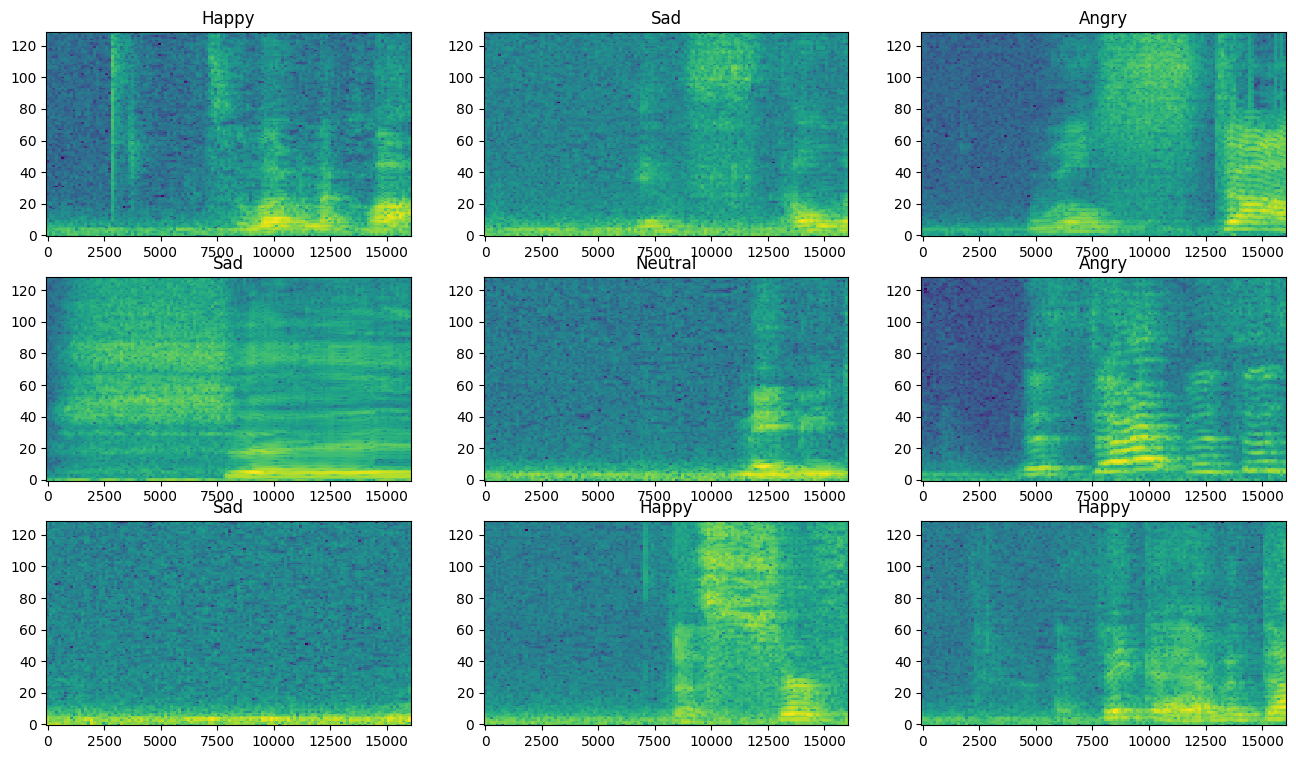

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy().argmax()])

plt.show()

In [19]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(1000)

In [20]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = tf.keras.layers.Normalization()
# norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = tf.keras.models.Sequential([
                                tf.keras.layers.Input(shape=input_shape),
                                tf.keras.layers.Resizing(32, 32),
                                norm_layer,
                                tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                tf.keras.layers.MaxPooling2D(),
                                tf.keras.layers.Dropout(0.25),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(128, activation='relu'),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(num_labels),
                                ])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [21]:
model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=[
                    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall'),
                    tf.keras.metrics.AUC(name='auc')
                    ]
            )

In [22]:
EPOCHS = 300
history = model.fit(
                    train_spectrogram_ds,
                    validation_data=val_spectrogram_ds,
                    epochs=EPOCHS
                    )

Epoch 1/300
321/321 [==============================] - 14s 20ms/step - loss: 1.5057 - accuracy: 0.3892 - precision: 0.2633 - recall: 0.6841 - auc: 0.7415 - val_loss: 1.3057 - val_accuracy: 0.4928 - val_precision: 0.2808 - val_recall: 0.8724 - val_auc: 0.8059
Epoch 2/300
321/321 [==============================] - 3s 8ms/step - loss: 1.2518 - accuracy: 0.4940 - precision: 0.2712 - recall: 0.8345 - auc: 0.7826 - val_loss: 1.1360 - val_accuracy: 0.5423 - val_precision: 0.2950 - val_recall: 0.8646 - val_auc: 0.8129
Epoch 3/300
321/321 [==============================] - 3s 8ms/step - loss: 1.1584 - accuracy: 0.5215 - precision: 0.2813 - recall: 0.8560 - auc: 0.7941 - val_loss: 1.0880 - val_accuracy: 0.5658 - val_precision: 0.2832 - val_recall: 0.8893 - val_auc: 0.8065
Epoch 4/300
321/321 [==============================] - 3s 9ms/step - loss: 1.1121 - accuracy: 0.5467 - precision: 0.2900 - recall: 0.8397 - auc: 0.7975 - val_loss: 1.0570 - val_accuracy: 0.5762 - val_precision: 0.3046 - val_rec

In [24]:
model.save('artifacts/emotion_model.h5')

In [26]:
history_cp = history.history.copy()
history_cp['loss'] = np.cumsum(history_cp['loss']) / np.arange(1, len(history_cp['loss']) + 1)
history_cp['val_loss'] = np.cumsum(history_cp['val_loss']) / np.arange(1, len(history_cp['val_loss']) + 1)

history_cp['accuracy'] = np.cumsum(history_cp['accuracy']) / np.arange(1, len(history_cp['accuracy']) + 1)
history_cp['val_accuracy'] = np.cumsum(history_cp['val_accuracy']) / np.arange(1, len(history_cp['val_accuracy']) + 1)

history_cp['precision'] = np.cumsum(history_cp['precision']) / np.arange(1, len(history_cp['precision']) + 1)
history_cp['val_precision'] = np.cumsum(history_cp['val_precision']) / np.arange(1, len(history_cp['val_precision']) + 1)

history_cp['recall'] = np.cumsum(history_cp['recall']) / np.arange(1, len(history_cp['recall']) + 1)
history_cp['val_recall'] = np.cumsum(history_cp['val_recall']) / np.arange(1, len(history_cp['val_recall']) + 1)

history_cp['auc'] = np.cumsum(history_cp['auc']) / np.arange(1, len(history_cp['auc']) + 1)
history_cp['val_auc'] = np.cumsum(history_cp['val_auc']) / np.arange(1, len(history_cp['val_auc']) + 1)

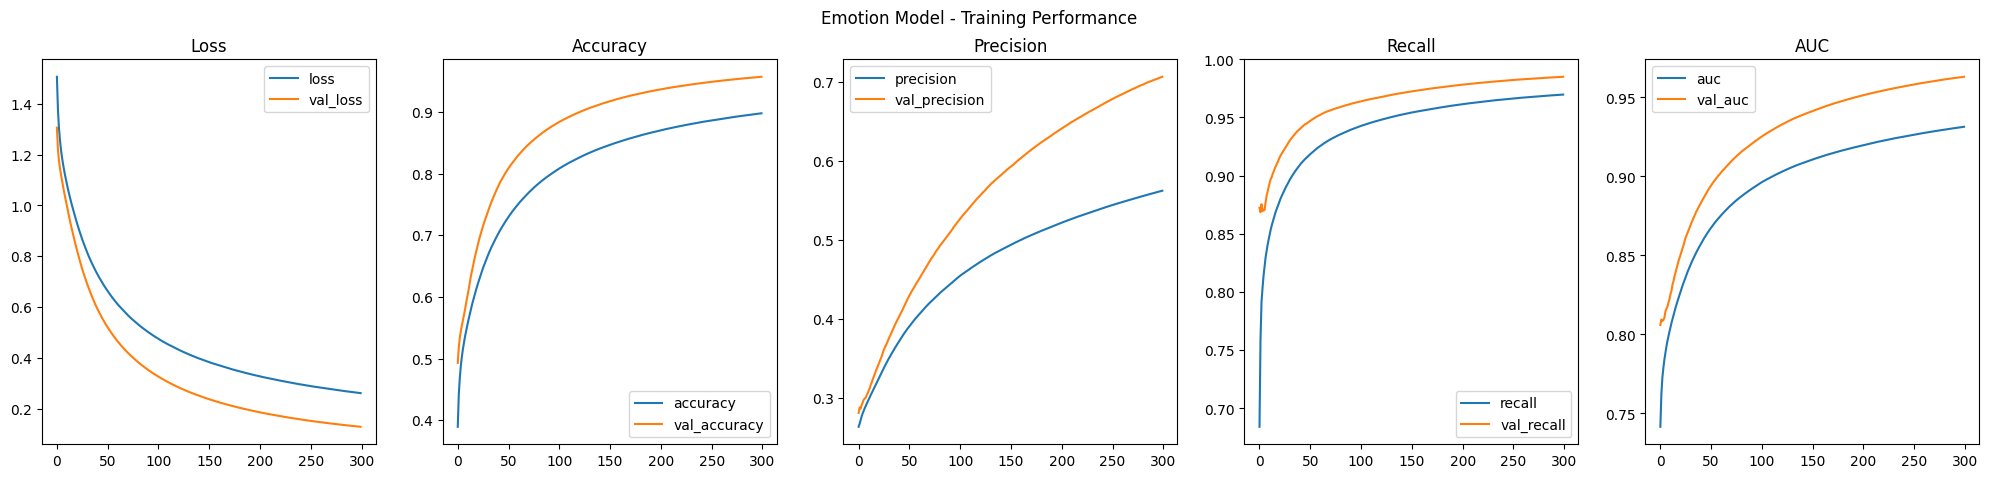

In [27]:
# Plot history_cp
plt.figure(figsize=(25, 5))
plt.subplot(1, 5, 1)
plt.plot(history_cp['loss'], label='loss')
plt.plot(history_cp['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 5, 2)
plt.plot(history_cp['accuracy'], label='accuracy')
plt.plot(history_cp['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 5, 3)
plt.plot(history_cp['precision'], label='precision')
plt.plot(history_cp['val_precision'], label='val_precision')
plt.legend()
plt.title('Precision')

plt.subplot(1, 5, 4)
plt.plot(history_cp['recall'], label='recall')
plt.plot(history_cp['val_recall'], label='val_recall')
plt.legend()
plt.title('Recall')

plt.subplot(1, 5, 5)
plt.plot(history_cp['auc'], label='auc')
plt.plot(history_cp['val_auc'], label='val_auc')
plt.legend()
plt.title('AUC')

plt.suptitle('Emotion Model - Training Performance')
plt.show()

In [28]:
# Evaluation

model = tf.keras.models.load_model('artifacts/emotion_model.h5')
model.evaluate(val_spectrogram_ds)

48/48 [==============================] - 1s 8ms/step - loss: 0.0074 - accuracy: 0.9993 - precision: 0.8792 - recall: 0.9993 - auc: 0.9904


[0.007403206545859575,
 0.9993489384651184,
 0.8791523575782776,
 0.9993489384651184,
 0.9904403686523438]

In [30]:
Y, P = [], []
for x, y in val_spectrogram_ds:
    Y.append(y)
    P.append(model.predict(x, verbose=0))

Y = np.concatenate(Y)
P = np.concatenate(P)

Y = np.argmax(Y, axis=1)
P = np.argmax(P, axis=1)

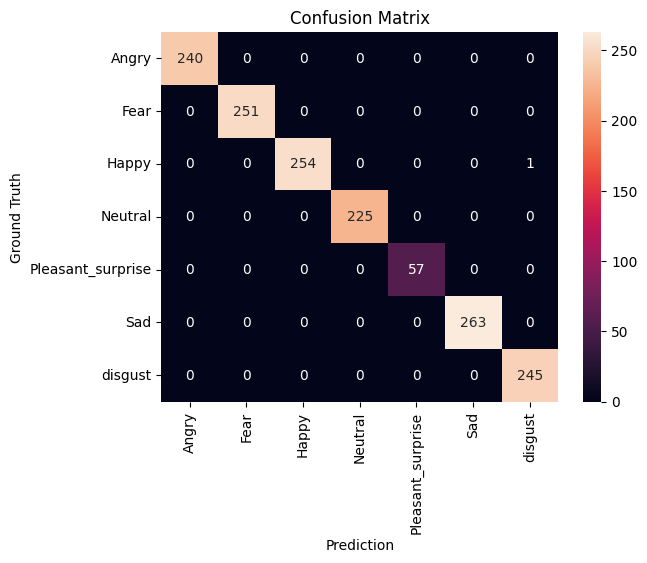

In [33]:
cm = tf.math.confusion_matrix(Y, P)
sns.heatmap(
            cm, 
            fmt='d',
            annot=True, 
            xticklabels=label_names, 
            yticklabels=label_names
            )
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()

### Inference

In [52]:
model_emotion = tf.keras.models.load_model('artifacts/emotion_model.h5')
model_emotion.compile(
                optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[
                        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')
                        ]
                )

In [57]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
                                waveform, 
                                frame_length=255, 
                                frame_step=128
                                )
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def inference_emotion(
                    audio_file,
                    class_dict = {
                                0: 'Angry',
                                1: 'Fear',
                                2: 'Happy',
                                3: 'Neutral',
                                4: 'Pleasant_surprise',
                                5: 'Sad',
                                6: 'disgust'
                                },
                    output_sequence_length=16000
                    ):
    raw_audio = tf.io.read_file(audio_file)
    waveform = tf.audio.decode_wav(raw_audio).audio
    waveform = tf.squeeze(waveform, axis=-1)
    waveform_length = tf.shape(waveform)[0]
    if waveform_length < output_sequence_length:
        waveform = tf.concat([waveform, tf.zeros(output_sequence_length - waveform_length)], 0)
    elif waveform_length > output_sequence_length:
        waveform = waveform[:output_sequence_length]
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, axis=0)
    
    prediction = model_emotion.predict(spectrogram)
    prediction = tf.nn.softmax(prediction)
    prediction = tf.squeeze(prediction, axis=0)
    prediction = prediction.numpy().argmax()
    prediction = class_dict[prediction]
    return prediction

In [58]:
inference_emotion('data/TESS/Angry/1001_DFA_ANG_XX.wav')

1/1 [==============================] - 0s 19ms/step


'Angry'